# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1205+4110

**Author(s)**: Sulyman Hossain, S M Rafee Adnan, Anowar Shajib <br>
**Acknowledgement**: Ahmad Al - Imtiaz

## Import Libraries

In [1]:
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.cosmology import FlatLambdaCDM
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

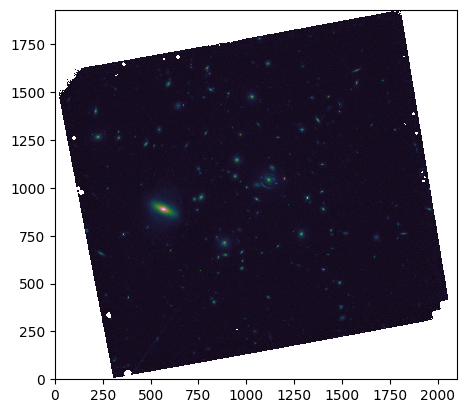

In [3]:
data, header = fits.getdata("/kaggle/input/fits-file/DESIJ12054110_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_18/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


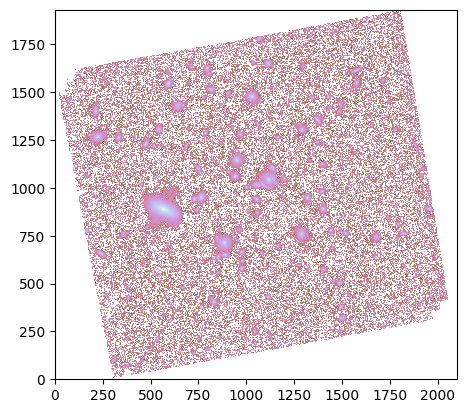

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

/tmp/ipykernel_18/511389273.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


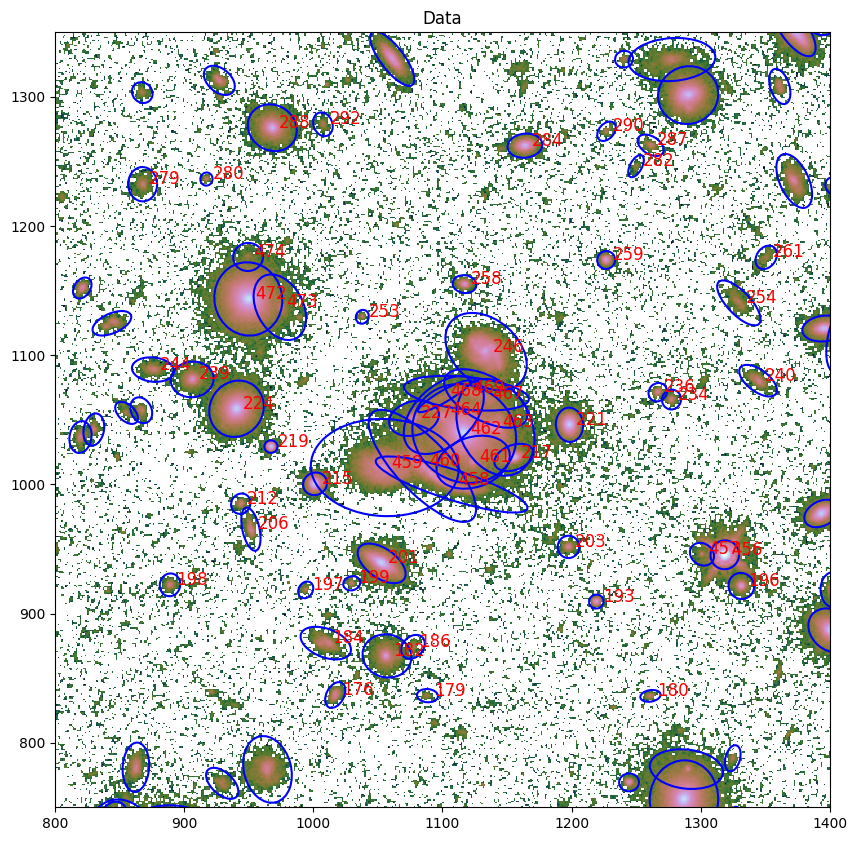

In [5]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 5 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[462]) < 250
        and np.abs(cat.ycentroid[i] - cat.ycentroid[462]) < 250
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 800, 1400
set_y_lim1, set_y_lim2 = 750, 1350

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

/tmp/ipykernel_18/2459307328.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


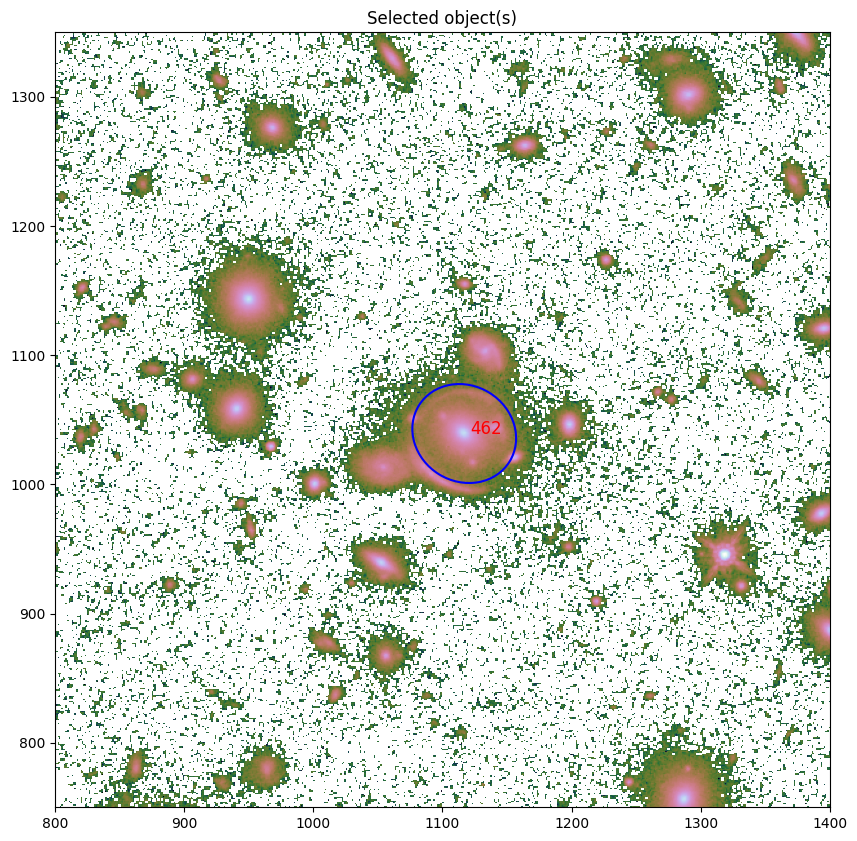

In [6]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = 462

# Calling the function label id_central
label_selected_objects([id_central])

In [7]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [8]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 47


In [9]:
# Close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 34


## Pixels to Megaparsec unit

In [10]:
def distance_parsec(pixel_distance):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180
    
    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian
    
    # Define cosmological parameters
    H0 = 70   # Hubble constant in km/s/Mpc
    Om0 = 0.3 # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Define the redshifts at which you want to compute the angular diameter distance
    z = 0.581
    
    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)
    
    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian 

    return physical_distances_mpc

## Identify the unwanted objects

/tmp/ipykernel_18/2459307328.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


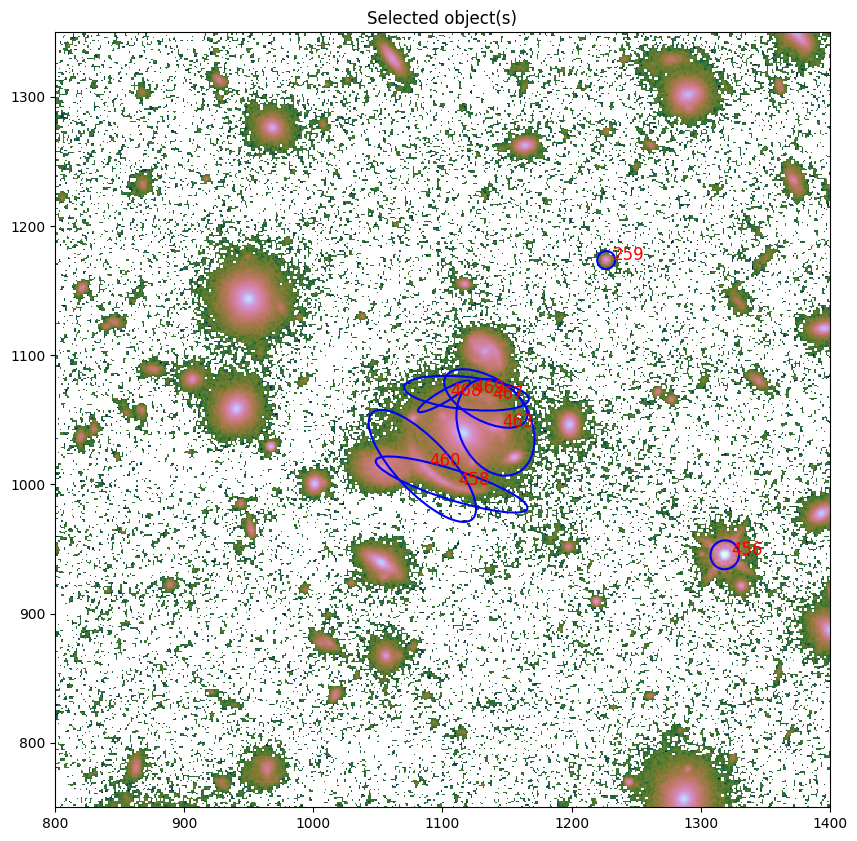

In [11]:
selected_object_ids = [463, 469, 467, 468, 458, 460, 259, 456]
label_selected_objects(selected_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [12]:
# All close galaxies

# lens galaxy: 462
# ARC objects: 463, 469, 467, 468, 458, 460
remove_list = [
    462,
    463,
    469,
    467,
    468,
    458,
    460,
]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratio
464         21.363922              0.011255  235.920443    0.614467
461         23.252378              0.012250  141.526328    0.661717
227         40.638350              0.021409   70.703469    0.666984
217         42.690653              0.022490   93.135690    0.609441
246         65.627284              0.034573  317.216603    0.697718
459         66.919078              0.035254  376.934208    0.656407
221         81.764235              0.043074  201.315648    0.792928
258        115.641628              0.060921   23.498824    0.745520
201        119.131816              0.062760  325.244725    0.537086
203        119.248714              0.062822   12.017500    0.967404
253        119.976320              0.063205    2.590624    0.892507
215        121.900078              0.064218  134.832992    0.919106
199        144.999689              0.076387    3.873261    0.810315
219        149.970967              0.079006   52

In [13]:
# Excluding galaxies lower than 1% of the central deflector

# lens galaxy: 462
# ARC objects: 463, 469, 467, 468, 458, 460
# Probable Stars: 259, 456
remove_list_1 = [
    462,
    463,
    469,
    467,
    468,
    458,
    460,
    259,
    456,
]

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)        Flux  Axis Ratioe
464         21.363922              0.011255  235.920443     0.614467
461         23.252378              0.012250  141.526328     0.661717
227         40.638350              0.021409   70.703469     0.666984
217         42.690653              0.022490   93.135690     0.609441
246         65.627284              0.034573  317.216603     0.697718
459         66.919078              0.035254  376.934208     0.656407
221         81.764235              0.043074  201.315648     0.792928
258        115.641628              0.060921   23.498824     0.745520
201        119.131816              0.062760  325.244725     0.537086
215        121.900078              0.064218  134.832992     0.919106
219        149.970967              0.079006   52.411847     0.954327
193        165.486367              0.087180   20.365859     0.951687
473        173.005948              0.091142   50.005781     0.661486
224        177.319865             

## Visualization

/tmp/ipykernel_18/432903831.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/432903831.py:22: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/432903831.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_18/432903831.py:28: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


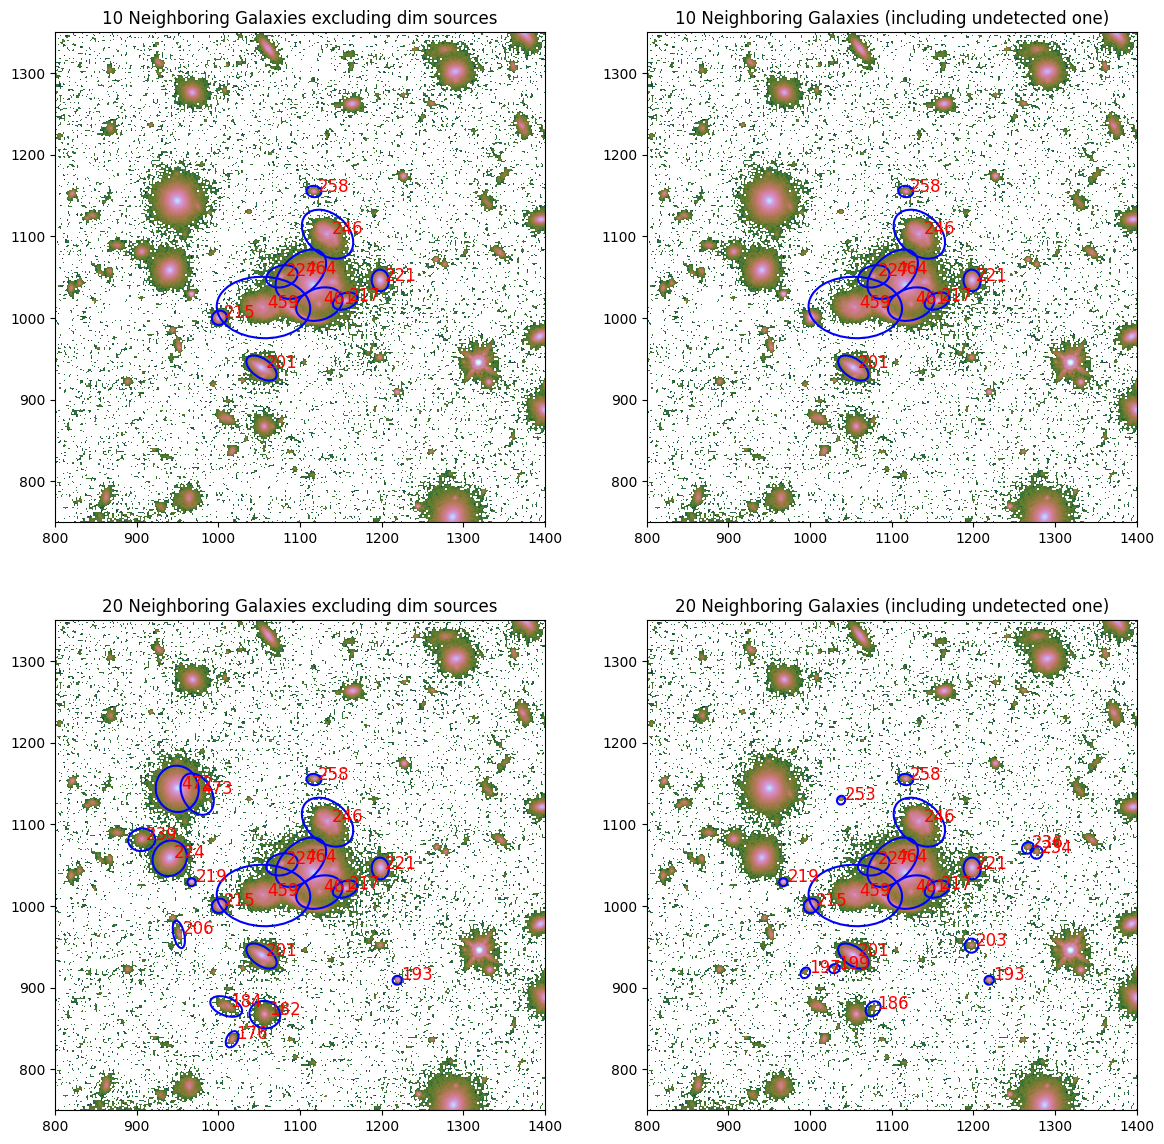

In [14]:
close_ids_all = list(df_all_20.index.values)
close_ids_all.pop(19)
close_ids_all_10 = close_ids_all[:10]
close_ids_all_10.pop(9)

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:9]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies (including undetected one)")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies (including undetected one)")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

## Loading Global Mean

In [15]:
# Read flux data from each YAML file and append to corresponding lists
input_path = f"/kaggle/input/global-means/DESIJ12054110_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load {lens_name}: {e}")
    
global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Method A

In [16]:
# One faint object (along 6 o'clock) near the lens galaxy was undetected due to
# threshold conditions. To include this object in the calculation, we only take
# the distance of the 9th and 19th closest galaxies to calculate R_10 and R_20,
# which includes dim sources.
# For all sources
R_10_all = df_all_20.iloc[8, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_all = df_all_20.iloc[18, df_all_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# But we are not considering the previously described faint object in the list that
# excludes dim objects
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")] ## Change
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.06276000164010935
R 20: 0.09081732983709273
Sigma 10: 808.1355926382165
Sigma 20: 771.8673404031864

EXCLUDING DIM SOURCES
R 10: 0.06421835364123211
R 20: 0.1189175963483764
Sigma 10: 771.848016562598
Sigma 20: 450.1817429717894


## Method B

In [17]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:9] / global_mean_flux_10)
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:19] / global_mean_flux_20)
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10] / global_mean_flux_selected_10)
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20] / global_mean_flux_selected_20)
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.06276000164010935
R 20: 0.09081732983709273
Sigma 10_updated: 1192.0549338297385
Sigma 20_updated: 877.2474372320619

EXCLUDING DIM SOURCES
R 10: 0.06421835364123211
R 20: 0.1189175963483764
Sigma 10_updated: 730.1336250006655
Sigma 20_updated: 467.12677072092606


## Method C

In [18]:
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# for all sources
for i in range(19):
    flux_all = df_all_20["Flux"][i:i+1] / df_all_20["Distance(megaparsec)"][i:i+1]
    
    if i < 9:
        flux_d_10_all.append(flux_all)
        flux_d_20_all.append(flux_all)
        
    elif 8 < i < 19:
        flux_d_20_all.append(flux_all)
        
weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20
Sigma_10_allC = weighted_flux_10_all  / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i:i+1] / df_1_20["Distance(megaparsec)"][i:i+1]
    
    if i < 10:
        flux_d_10_1.append(flux_1)
        flux_d_20_1.append(flux_1)
        
    elif 9 < i < 20:
        flux_d_20_1.append(flux_1)
        
weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_dis_selected_20
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)



print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06276000164010935
R 20: 0.09081732983709273
Sigma 10_updated: 1094.0495406626376
Sigma 20_updated: 926.9787632518355

EXCLUDING DIM SOURCES
R 10: 0.06421835364123211
R 20: 0.1189175963483764
Sigma 10_updated: 904.8063956455836
Sigma 20_updated: 535.8526381241261


## Method D

In [19]:
# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125 # for 10 arcseconds
s = distance_parsec(pixel_distance).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]
    
    # Processing for df_all_20
    if i < 9:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)
        
    elif 8 < i < 19:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all
        
        flux_d_20_all.append(flux_contrib_all)
    
    # Processing for df_1_20
    if i < 10:
        
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)
        
    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1
        
        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_dis_selected_20
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)


# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)



Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.06276000164010935
R 20: 0.09081732983709273
Sigma 10_updated: 423.36017005182975
Sigma 20_updated: 385.6007512789513

EXCLUDING DIM SOURCES
R 10: 0.06421835364123211
R 20: 0.1189175963483764
Sigma 10_updated: 365.61407121428186
Sigma 20_updated: 275.9077843962136


## Store the results to the YAML file

In [20]:
import shutil
src_path = r"/kaggle/input/point-estimates/DESIJ12054110_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ12054110_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

## Determining the mean for normalizing

In [21]:
#Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:9])
flux_20_mean = np.mean(df_all_20["Flux"][0:19])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:9])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:19])

#Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

198.3884376719471 107.25318963847397 198.3884376719471 186.35548705680173
3012.667197569545 1612.5767253685074 2916.1538082504803 2282.3590154245335


In [22]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [23]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1205+4110_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ1205+4110_means.yml' created successfully.
